# Basic Data Visualization of SAILS data

In [46]:
EXCEL_PATH = "/orcd/data/satra/002/datasets/SAILS/data4analysis/Video Rating Data/SAILS_RATINGS_ALL_8.8.25.xlsx"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 160)

In [47]:
# Requires openpyxl
df = pd.read_excel(EXCEL_PATH, engine="openpyxl")

### Overview

In [48]:
print(f"Total Annotations: {len(df)}")
print(f"Unique Videos (SourceFile): {len(df['SourceFile'].unique())}")
print(f"Unique participants (ID): {df['ID'].nunique()}")
print("Attributes per Annotation:")
og_cols = df.columns
for col in og_cols:
    print(" -", col)

Total Annotations: 3902
Unique Videos (SourceFile): 3525
Unique participants (ID): 151
Attributes per Annotation:
 - Coder
 - SourceFile
 - ID
 - FileName
 - Vid_duration
 - DOB
 - Vid_date
 - Age_in_months
 - time_point
 - Context
 - Location
 - Activity
 - Child_of_interest_clear
 - #_adults
 - #_children
 - #_people_background
 - Interaction_with_child
 - #_people_interacting
 - Child_constrained
 - Constraint_type
 - Supports
 - Support_type
 - Example_support_type
 - Gestures
 - Gesture_type
 - Vocalizations
 - RMM
 - RMM_type
 - Response_to_name
 - Locomotion
 - Locomotion_type
 - Grasping
 - Grasp_type
 - Body_Parts_Visible
 - Angle_of_Body
 - Video_Quality_Child_Face_Visibility
 - Video_Quality_Child_Body_Visibility
 - Video_Quality_Child_Hand_Visibility
 - Video_Quality_Lighting
 - Video_Quality_Resolution
 - Video_Quality_Motion
 - Notes


In [49]:
dupes = df[df.duplicated(subset=["SourceFile"], keep=False)]
print("Videos with >1 annotation:", dupes["SourceFile"].nunique())

Videos with >1 annotation: 377


### Data Cleaning

In [50]:
# --- Helpers ---

def strip_strings(df, cols=None):
    """Strip whitespace and standardize empty-like strings to NaN for object columns."""
    if cols is None:
        cols = df.select_dtypes(include=["object"]).columns.tolist()
    for c in cols:
        df[c] = (df[c].astype(str)
                    .str.strip()
                    .replace({"": np.nan, "nan": np.nan, "None": np.nan}))
    return df

def coerce_datetime(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def coerce_time_to_seconds(series):
    """Convert pandas/datetime.time-like durations to seconds (float)."""
    out = []
    for v in series:
        if pd.isna(v):
            out.append(np.nan)
            continue
        if hasattr(v, "hour"):
            # datetime.time or Timestamp
            seconds = v.hour*3600 + v.minute*60 + v.second + (getattr(v, "microsecond", 0) or 0)/1e6
            out.append(seconds)
        else:
            # try parse generic
            try:
                out.append(pd.to_timedelta(v).total_seconds())
            except Exception:
                out.append(np.nan)
    return pd.Series(out, index=series.index)

def to_numeric_lower_bound(x):
    """
    Numeric feature for analysis:
    - '5+' -> 5   (lower bound)
    - '10+' -> 10
    - '+' -> NaN  (ambiguous)
    - digits -> int
    - other/NaN -> NaN
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.isdigit():
        return int(s)
    if s.endswith("+") and s[:-1].isdigit():
        return int(s[:-1])
    return np.nan

def to_viz_bin(x, collapse_high_at=None):
    """
    Categorical feature for plotting:
    - digits -> keep as string, but if collapse_high_at is set and value >= threshold -> '≥{threshold}'
    - 'd+' -> '≥d'
    - '+'  -> 'Unknown+'
    - NaN  -> NaN
    - other strings -> keep (as-is)
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # 'd+' -> '≥d'
    if s.endswith("+") and s[:-1].isdigit():
        return f"≥{int(s[:-1])}"
    if s == "+":
        return "Unknown (+)"
    # plain digits
    if s.isdigit():
        v = int(s)
        if collapse_high_at is not None and v >= collapse_high_at:
            return f"≥{int(collapse_high_at)}"
        return str(v)
    return s  # leave other labels as-is

def make_numeric_and_plot_bins(df, col, collapse_high_at=None):
    """
    Creates two new columns:
    - <col>_num  : numeric lower-bound version (for stats)
    - <col>_plot : categorical-binned version (for visualization)
    """
    num_col = f"{col}_num"
    plot_col = f"{col}_plot"
    df[num_col] = df[col].map(to_numeric_lower_bound)
    df[plot_col] = df[col].map(lambda x: to_viz_bin(x, collapse_high_at=collapse_high_at))
    return num_col, plot_col

def standardize_categories(df):
    """Fix common typos/variants and harmonize categories."""
    replace_map = {
        # Locations
        "outside oublic": "outside public",
        "outside public ": "outside public",
        "outside private ": "outside private",
        "inside public ": "inside public",
        "inside private ": "inside private",
        "unknown ": "unknown",
        # time_point
        "14_month ": "14_month",
        "36_month ": "36_month",
        # booleans/yes-no fields
        "yes ": "yes",
        "no ": "no",
        "n/a ": "n/a",
        # gestures
        "mutiple": "multiple",
        "clapping": "clap",
        "reach ": "reach",
        # body parts
        "both ": "both",
        # angle
        "front ": "front",
        "variable ": "variable",
        # locomotion type
        "walk ": "walk",
        "crawl ": "crawl",
        # constraint type
        "highchair": "high chair",
    }
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].replace(replace_map)
    return df

def coerce_quality_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def to_categorical(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype("category")
    return df

In [51]:
# --- Cleaning ---

df = strip_strings(df)

# harmonize common categorical variants
df = standardize_categories(df)

# Parse datetime columns
datetime_cols = ["DOB", "Vid_date"]
df = coerce_datetime(df, datetime_cols)

# Duration to seconds
if "Vid_duration" in df.columns:
    df["Vid_duration_s"] = coerce_time_to_seconds(df["Vid_duration"])

# Coerce count-like columns that may contain '10+' or '+'
count_cols = ["#_adults", "#_children", "#_people_background", "#_people_interacting"]
for c in count_cols:
    if c in df.columns:
        make_numeric_and_plot_bins(df, c)
        # df[c + "_num"] = df[c].apply(make_numeric_and_plot_bins)

# Coerce video quality metrics to numeric
quality_cols = [
    "Video_Quality_Child_Face_Visibility",
    "Video_Quality_Child_Body_Visibility",
    "Video_Quality_Child_Hand_Visibility",
    "Video_Quality_Lighting",
    "Video_Quality_Resolution",
    "Video_Quality_Motion",
]
df = coerce_quality_numeric(df, quality_cols)

# Ensure expected categorical columns are categories
cat_cols = [
    "time_point","Context","Location","Activity","Child_of_interest_clear",
    "Interaction_with_child","Child_constrained","Constraint_type",
    "Supports","Support_type","Gestures","Gesture_type","Vocalizations",
    "RMM","RMM_type","Response_to_name","Locomotion","Locomotion_type",
    "Grasping","Grasp_type","Body_Parts_Visible","Angle_of_Body","Coder"
]
df = to_categorical(df, [c for c in cat_cols if c in df.columns])

# Recompute Age_in_months if missing and DOB/Vid_date available
if "Age_in_months" in df.columns:
    mask_missing_age = df["Age_in_months"].isna() & df["DOB"].notna() & df["Vid_date"].notna()
    if mask_missing_age.any():
        delta_days = (df.loc[mask_missing_age, "Vid_date"] - df.loc[mask_missing_age, "DOB"]).dt.days
        df.loc[mask_missing_age, "Age_in_months"] = delta_days / 30.44

print("After cleaning:", df.shape)
df.head()

After cleaning: (3902, 51)


,Coder,SourceFile,ID,FileName,Vid_duration,DOB,Vid_date,Age_in_months,time_point,Context,...,Notes,Vid_duration_s,#_adults_num,#_adults_plot,#_children_num,#_children_plot,#_people_background_num,#_people_background_plot,#_people_interacting_num,#_people_interacting_plot
0,AD,/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/H.L._Home_Videos_AMES_A6Y4Y7X2G1/12-16 month videos/Dec 2018 (14m)/12-02-2018.MOV,A6Y4Y7X2G1,12-02-2018.MOV,00:00:10,2017-10-31,2018-12-19,13.608501,14_month,daily routine,...,NaN,10.0,0.0,0,1.0,1,0.0,0,0.0,0
1,AD,/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/H.L._Home_Videos_AMES_A6Y4Y7X2G1/12-16 month videos/Dec 2018 (14m)/12-09-2018.MOV,A6Y4Y7X2G1,12-09-2018.MOV,00:00:35.100000,2017-10-31,2018-12-12,13.378521,14_month,toy play,...,Books are present but child is using them like toys and they are not being read,35.1,0.0,0,1.0,1,0.0,0,1.0,1
2,AD,/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/H.L._Home_Videos_AMES_A6Y4Y7X2G1/12-16 month videos/Dec 2018 (14m)/12-11-2018.MOV,A6Y4Y7X2G1,12-11-2018.MOV,00:01:40.400000,2017-10-31,2018-12-28,13.904189,14_month,toy play,...,NaN,100.4,1.0,1,1.0,1,0.0,0,1.0,1
3,AD,/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/H.L._Home_Videos_AMES_A6Y4Y7X2G1/12-16 month videos/Dec 2018 (14m)/12-22-2018.MOV,A6Y4Y7X2G1,12-22-2018.MOV,00:00:15.400000,2017-10-31,2018-12-22,13.707063,14_month,toy play,...,NaN,15.4,0.0,0,1.0,1,0.0,0,1.0,1
4,AD,/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/H.L._Home_Videos_AMES_A6Y4Y7X2G1/12-16 month videos/Dec 2018 (14m)/12-29-2018.MOV,A6Y4Y7X2G1,12-29-2018.MOV,00:01:01.200000,2017-10-31,2018-12-20,13.641355,14_month,general social communication interaction,...,Adult in second half could be considered foreground as he was with the child but the child was so far away (in background),61.2,0.0,0,1.0,1,1.0,1,2.0,2


### Reports

In [52]:
# --- Availablity ---
n = len(df)

pct_avail = df[og_cols].notna().mean() * 100
count_avail = df[og_cols].notna().sum()

avail_df = pd.DataFrame({
    "Attribute": pct_avail.index,
    "Availability (%)": pct_avail.values,
    "Count": count_avail.values
}).sort_values("Availability (%)", ascending=False)

avail_df

,Attribute,Availability (%),Count
0,Coder,100.000000,3902
2,ID,100.000000,3902
3,FileName,100.000000,3902
5,DOB,100.000000,3902
1,SourceFile,100.000000,3902
4,Vid_duration,99.846233,3896
13,#_adults,97.590979,3808
20,Supports,97.590979,3808
16,Interaction_with_child,97.590979,3808
14,#_children,97.590979,3808


In [53]:
# --- Numeric summaries ---
exclude = ["Age_in_months"] 
numeric_cols = df.drop(columns=exclude).select_dtypes(include=[np.number]).columns.tolist()
desc = df[numeric_cols].describe().T
desc

,count,mean,std,min,25%,50%,75%,max
Video_Quality_Child_Face_Visibility,3807.0,6.415025,2.660421,1.0,4.0,7.0,9.0,10.0
Video_Quality_Child_Body_Visibility,3806.0,7.710457,1.885621,1.0,7.0,8.0,9.0,10.0
Video_Quality_Child_Hand_Visibility,3777.0,5.837437,2.175569,1.0,5.0,6.0,8.0,10.0
Video_Quality_Lighting,3777.0,9.683876,1.066456,1.0,10.0,10.0,10.0,10.0
Video_Quality_Resolution,3777.0,9.791898,0.792983,1.0,10.0,10.0,10.0,10.0
Video_Quality_Motion,3777.0,7.667726,1.671039,1.0,7.0,8.0,9.0,10.0
Vid_duration_s,3896.0,40.583214,49.886752,0.1,15.5,27.9,48.5,1036.8
#_adults_num,3808.0,0.304359,0.660382,0.0,0.0,0.0,1.0,10.0
#_children_num,3808.0,1.281250,0.776558,0.0,1.0,1.0,1.0,10.0
#_people_background_num,3782.0,0.279482,1.026698,0.0,0.0,0.0,0.0,10.0


### Visualizations

In [54]:
def _order_for_plot(idx):
    """
    Order categories:
    - numeric strings ascending (e.g., '0','1','2',...)
    - then '≥k' ascending by k
    - then other strings alphabetically
    """
    nums, ge, other = [], [], []
    for v in idx:
        m_ge = re.fullmatch(r"≥(\d+)", str(v))
        if isinstance(v, str) and v.isdigit():
            nums.append((int(v), v))
        elif m_ge:
            ge.append((int(m_ge.group(1)), v))
        else:
            other.append((str(v), v))
    ordered = [v for _, v in sorted(nums, key=lambda x: x[0])]
    ordered += [v for _, v in sorted(ge, key=lambda x: x[0])]
    ordered += [v for _, v in sorted(other, key=lambda x: x[0])]
    return ordered

def plot_bar_with_percent(series, title=None):
    """
    Bar chart with % labels and NaN kept as a bar.
    - Orders numeric-like categories logically.
    """
    vc = series.value_counts(dropna=False)
    # Convert NaN index to string 'NaN' for plotting
    vc.index = vc.index.map(lambda x: "NaN" if pd.isna(x) else x)

    # Order categories nicely
    order = _order_for_plot(vc.index)
    vc = vc.reindex(order)

    pct = vc / len(series) * 100

    plt.figure(figsize=(8,6))
    ax = vc.plot(kind="bar", edgecolor="black")
    plt.title(title or series.name)
    plt.xlabel(series.name or "")
    plt.ylabel("Count")
    for i, (count, p) in enumerate(zip(vc, pct)):
        if np.isnan(count):  # safety
            continue
        ax.text(i, count + (0.01 * vc.max() if vc.max() > 0 else 0.5), f"{p:.1f}%", ha="center")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

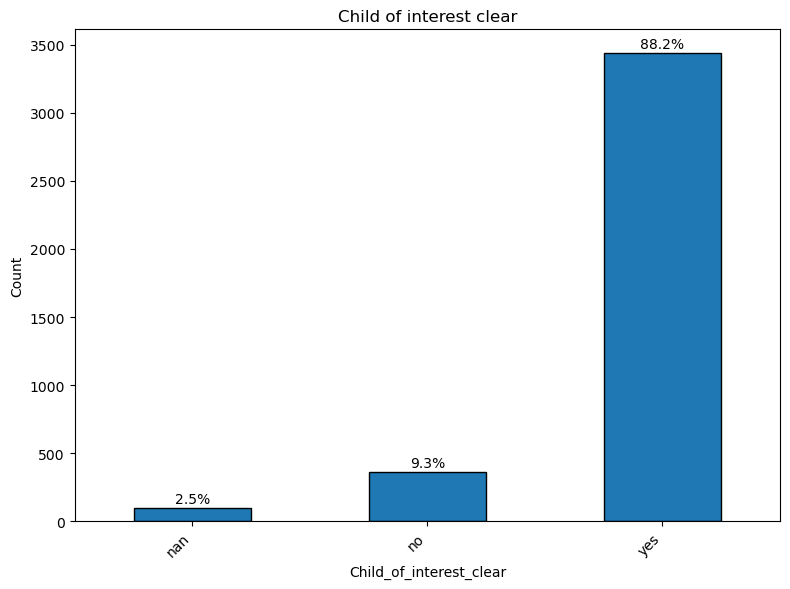

In [55]:
plot_bar_with_percent(df["Child_of_interest_clear"], title="Child of interest clear")

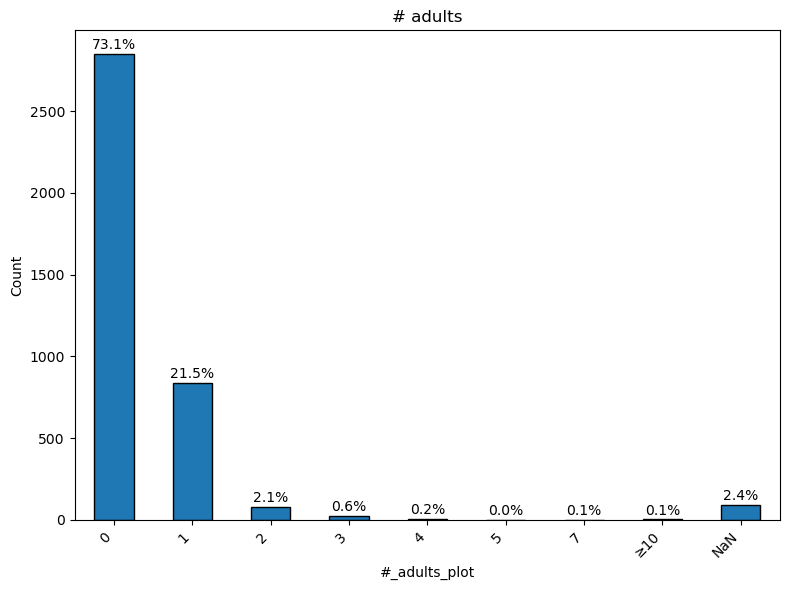

In [56]:
plot_bar_with_percent(df["#_adults_plot"], title="# adults")

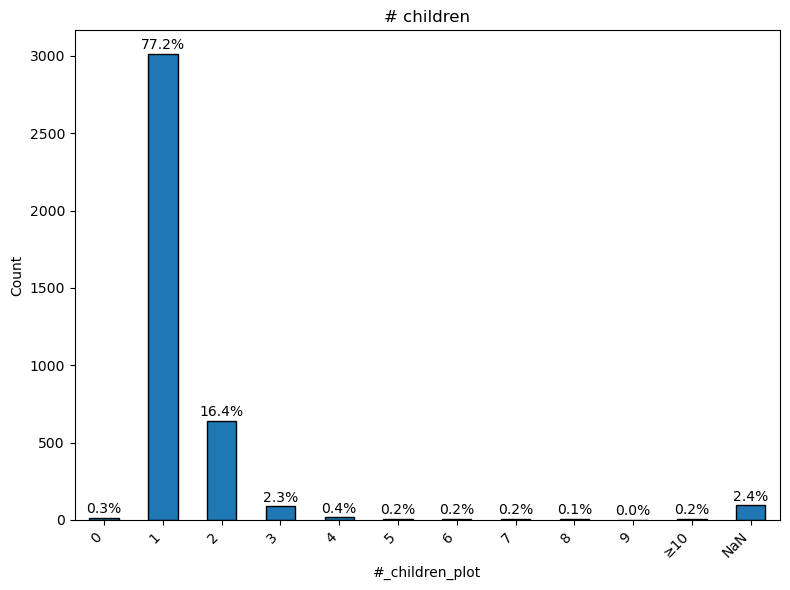

In [57]:
plot_bar_with_percent(df["#_children_plot"], title="# children")

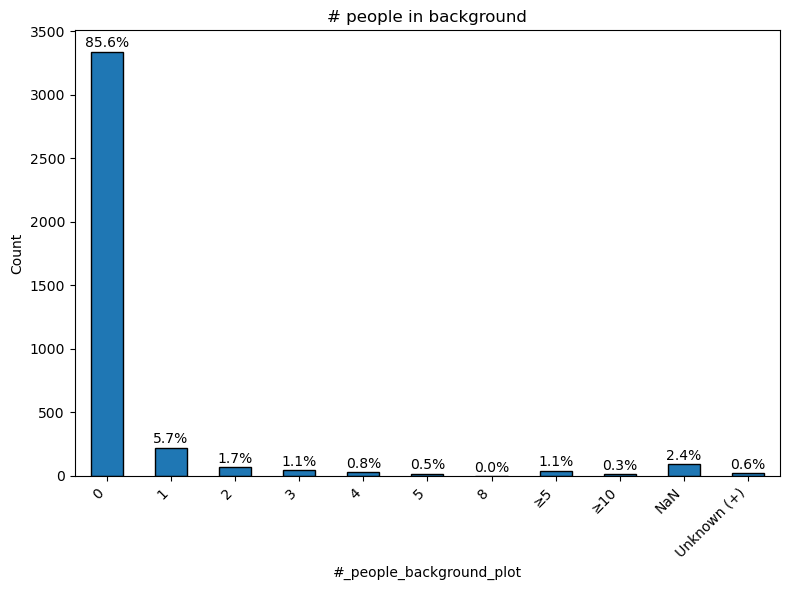

In [58]:
plot_bar_with_percent(df["#_people_background_plot"], title="# people in background")

### Investigating NaNs

In [59]:
of_interest = ["Child_of_interest_clear", "#_adults_plot", "#_children_plot", "#_people_background_plot"]

In [60]:
# count NaNs per attribute per ID
nan_counts_id = df[of_interest].isna().groupby(df["ID"]).sum()
nan_counts_id["TotalMissing"] = nan_counts_id.sum(axis=1)
nan_counts_id = nan_counts_id.sort_values("TotalMissing", ascending=False)
nan_counts_id.loc[nan_counts_id["TotalMissing"] > 0]

,Child_of_interest_clear,#_adults_plot,#_children_plot,#_people_background_plot,TotalMissing
ID,,,,,
H7B1M3P5D9,37,36,36,36,145
N3C7S2N8O0,9,9,9,9,36
D7O9E3F9P9,7,7,7,7,28
A2L1R9Y7C8,7,7,7,7,28
B8I6G9P2G8,5,5,5,5,20
S7F0B6H3A3,4,4,4,4,16
T2H0J0N2Z5,3,3,3,3,12
K6O1J5K7Z0,2,2,2,2,8
K8F9J9J1I2,2,2,2,2,8


In [61]:
# count NaNs per attribute per file
nan_counts_file = df[of_interest].isna().groupby(df["SourceFile"]).sum()
nan_counts_file["TotalMissing"] = nan_counts_file.sum(axis=1)
nan_counts_file = nan_counts_file.sort_values("TotalMissing", ascending=False)
nan_counts_file.loc[nan_counts_file["TotalMissing"] == 4]

,Child_of_interest_clear,#_adults_plot,#_children_plot,#_people_background_plot,TotalMissing
SourceFile,,,,,
/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/B.V._Home_Videos_AMES_B8I6G9P2G8/34-38 month videos/IMG_2500.mov,1,1,1,1,4
/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/C.S._Home_Videos_AMES_H7B1M3P5D9 3/34-38 months/IMG_2292.mov,1,1,1,1,4
/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/C.S._Home_Videos_AMES_H7B1M3P5D9/12-16 months/13585664_1722154758036318_133172189_n.mp4,1,1,1,1,4
/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/J.P._Home_Videos_AMES_S7F0B6H3A3/34-38 month videos/June.4.2021.MOV,1,1,1,1,4
/Volumes/T7 Shield/AMES_Phase_III/vid_check_liz/H.P._Home_Videos_AMES_F8N7H3T0O1/12-16 month videos/5-21-2021_2.mp4,1,1,1,1,4
...,...,...,...,...,...
/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/J.E._Home_Videos_AMES_A2L1R9Y7C8 2/34-38 month videos/09.27.2017.mov,1,1,1,1,4
/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/J.E._Home_Videos_AMES_A2L1R9Y7C8 2/12-16 month videos/07.10.2015.mov,1,1,1,1,4
/Volumes/T7 Shield/AMES_Phase_III/Phase_III_videos/J.E._Home_Videos_AMES_A2L1R9Y7C8 2/34-38 month videos/06.12.2017.mov,1,1,1,1,4


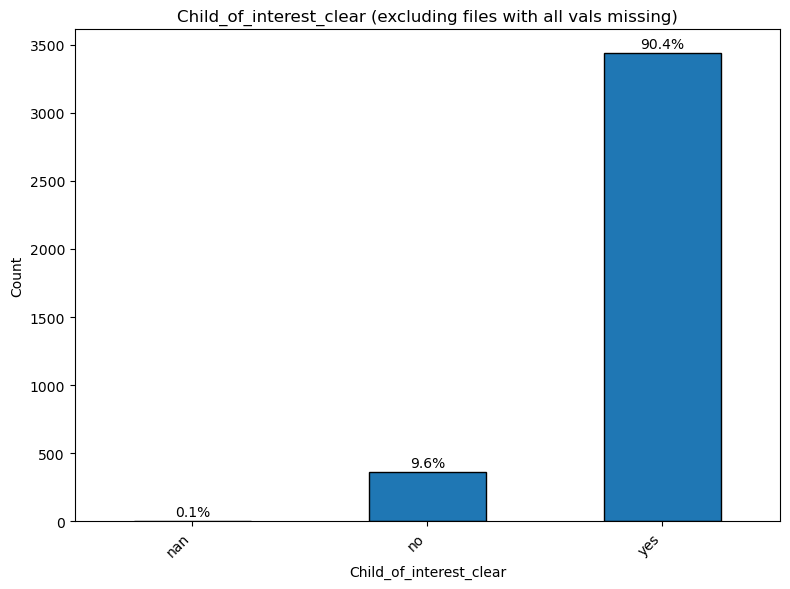

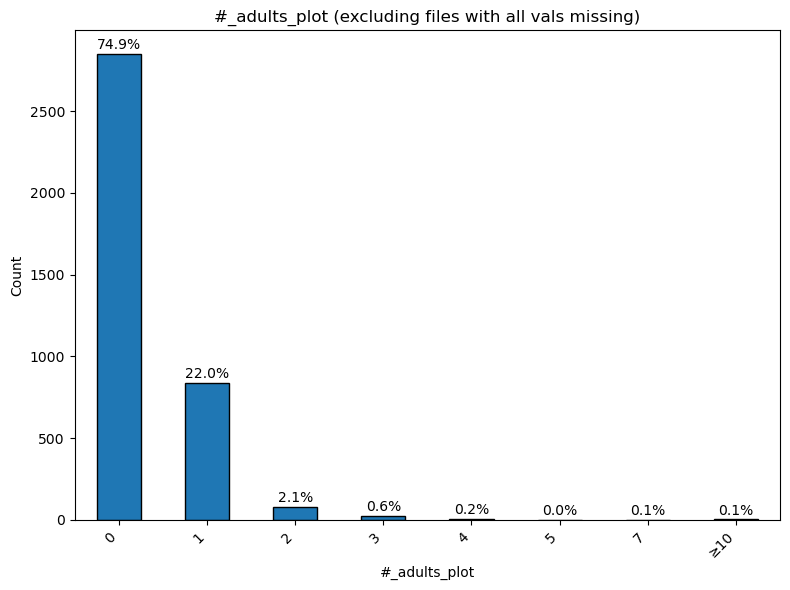

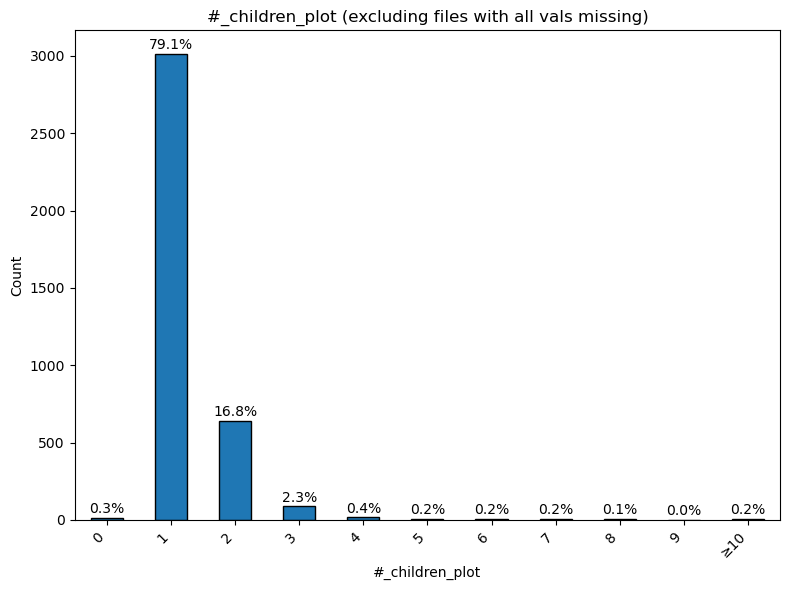

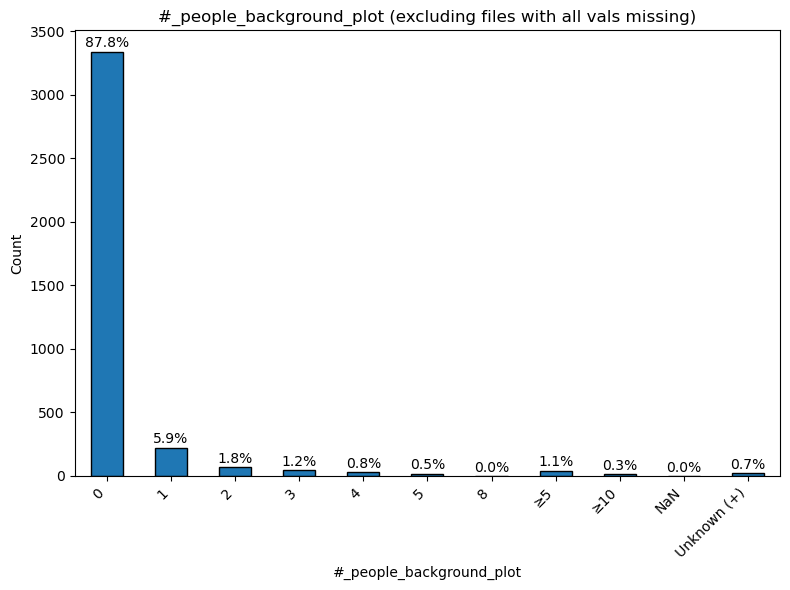

In [62]:
missing_all_attr = nan_counts_file.loc[nan_counts_file["TotalMissing"] == len(of_interest)].index.tolist()

for col in of_interest:
    subset = df.loc[~df["SourceFile"].isin(missing_all_attr), col]
    plot_bar_with_percent(subset, title=f"{col} (excluding files with all vals missing)")

In [63]:
bg_num_col = "#_people_background_num"
bg_plot_col = "#_people_background_plot"

if bg_num_col in df.columns:
    subset_zero_bg = df[df[bg_num_col] == 0]
else:
    subset_zero_bg = df[df.get(bg_plot_col) == "0"]

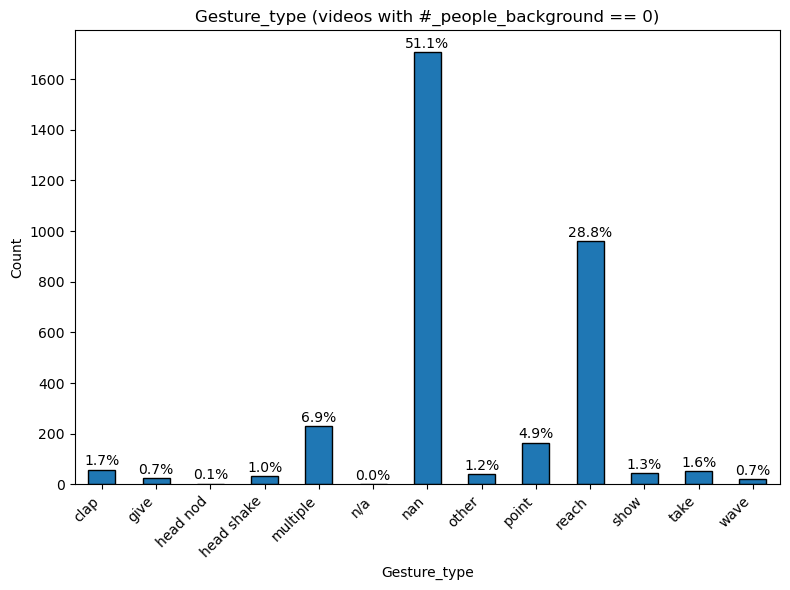

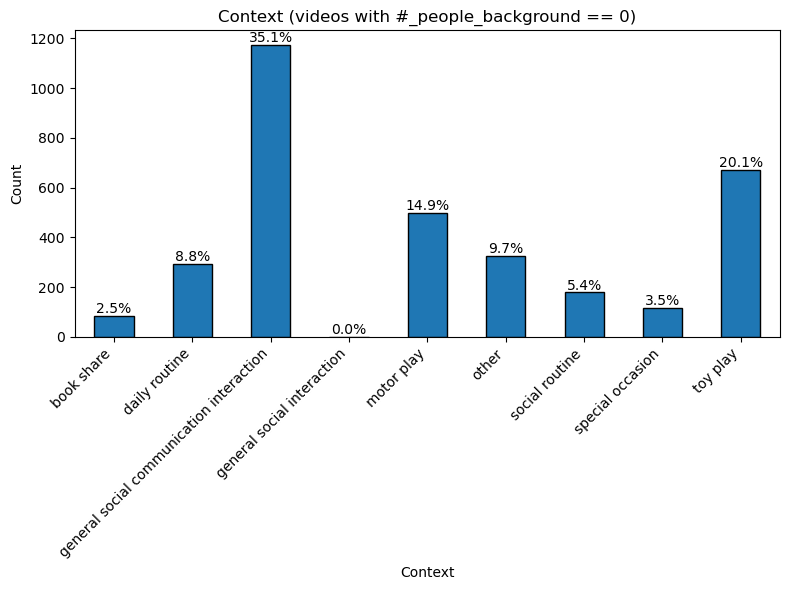

In [65]:
for col in ["Gesture_type", "Context"]:
    if col not in subset_zero_bg.columns:
        print(f"Column not found: {col}")
        continue
    ser = subset_zero_bg[col]
    vc = ser.value_counts(dropna=False)
    plot_bar_with_percent(ser, title=f"{col} (videos with #_people_background == 0)")

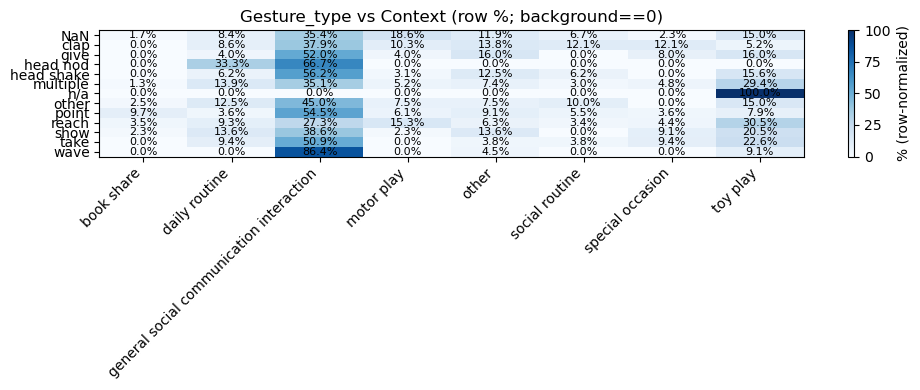

In [67]:

def as_obj_fillna(series, fill="NaN"):
    return series.astype(object).fillna(fill)

left = as_obj_fillna(subset_zero_bg["Gesture_type"])
right = as_obj_fillna(subset_zero_bg["Context"])
ct = pd.crosstab(left, right)
ct_pct = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0) * 100

fig, ax = plt.subplots(figsize=(10, max(4, 0.3 * len(ct_pct))))
im = ax.imshow(ct_pct.fillna(0).values, cmap="Blues", aspect="auto")
ax.set_xticks(range(len(ct_pct.columns)))
ax.set_xticklabels(ct_pct.columns, rotation=45, ha="right")
ax.set_yticks(range(len(ct_pct.index)))
ax.set_yticklabels(ct_pct.index)
ax.set_title("Gesture_type vs Context (row %; background==0)")
for i in range(ct_pct.shape[0]):
    for j in range(ct_pct.shape[1]):
        v = ct_pct.values[i, j]
        ax.text(j, i, f"{v:.1f}%", ha="center", va="center", fontsize=8)
fig.colorbar(im, ax=ax, label="% (row-normalized)")
plt.tight_layout()
plt.show()



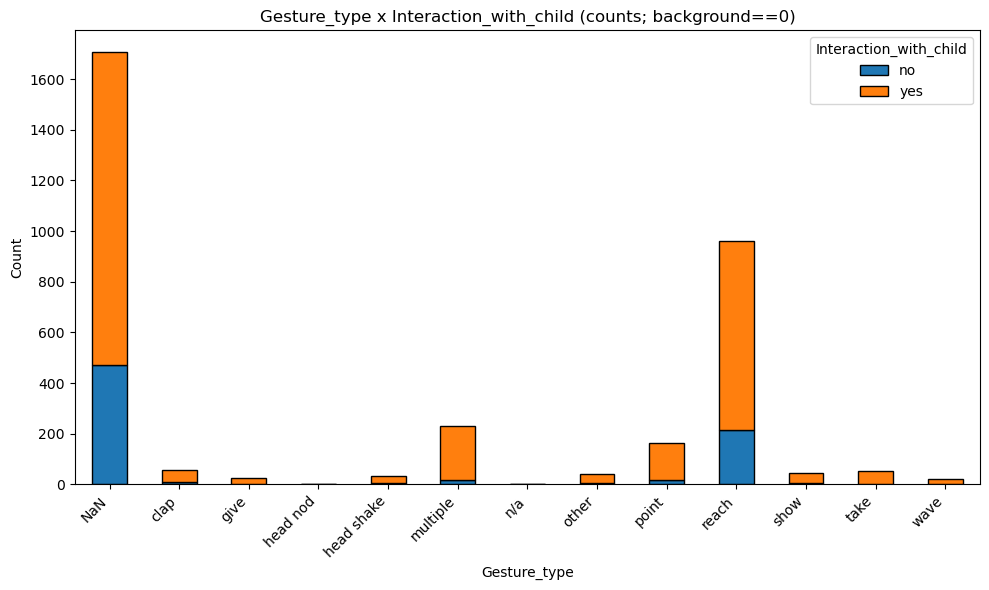

In [68]:
g = as_obj_fillna(subset_zero_bg["Gesture_type"])
it = as_obj_fillna(subset_zero_bg["Interaction_with_child"])
ct2 = pd.crosstab(g, it)
ax = ct2.plot(kind="bar", stacked=True, figsize=(10,6), edgecolor="black")
ax.set_title("Gesture_type x Interaction_with_child (counts; background==0)")
ax.set_xlabel("Gesture_type")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()